<a href="https://colab.research.google.com/github/neel26desai/cmpe258_neural_network_advanced/blob/main/Deeplearning_Using_Keras_and_Tensorflow_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

# Defining the data
n, d = 1000, 3  # 1000 records, 3 features

# Creating x, values will be between -1 and 1 and the shape will be n, d
x = np.random.uniform(-1, 1, (n, d))

# Creating weights that allow us to get the y_true values
weights_true = np.array([[1], [3], [1]], dtype=np.float32)
bias_true = np.array([1], dtype=np.float32)

# Creating an equation y_true using np.dot for matrix multiplication
y_true = np.dot(x**3, weights_true) + \
         np.dot(x**2, weights_true) + \
         np.dot(x, weights_true) + bias_true

print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (1000, 3), weights: (3, 1), bias: (1,), y: (1000, 1)


In [3]:
#create a train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_true, test_size=0.2, random_state=42)

In [4]:
#custom loss function
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [5]:
def create_huber(threshold=1.0):
  #custom loss function
  def huber_fn(y_true, y_pred):
      error = y_true - y_pred
      is_small_error = tf.abs(error) < threshold
      squared_loss = tf.square(error) / 2
      linear_loss  = tf.abs(error) - threshold**2 / 2
      return tf.where(is_small_error, squared_loss, linear_loss)
  return huber_fn

In [6]:
#Custom Regularizer
class MyRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

In [7]:
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [8]:
#custom metric  - huber
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}


In [9]:
#function for defining custom logic for initializing weights
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

#custom constraints for weights
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [10]:
#custom alpha dropout
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [11]:
#custom activation
def custom_activation(x):
    return tf.nn.relu(x) * tf.sigmoid(x)

In [12]:
#custom layer
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer=my_glorot_initializer)
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [13]:
from functools import partial
MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

In [40]:
K = tf.keras.backend
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [66]:
import keras

In [115]:
keras.__version__

'2.15.0'

In [121]:
# import tensorflow.compat.v2 as tf

from keras.optimizers import Optimizer


# isort: off
from tensorflow.python.util.tf_export import keras_export


# @register_keras_serializable()
# @keras_export(
#     "keras.optimizers.Adam",
#     "keras.optimizers.experimental.Adam",
#     "keras.dtensor.experimental.optimizers.Adam",
#     v1=[],
# )
class MyAdam(keras.optimizers.Optimizer):
    def __init__(
        self,
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        jit_compile=True,
        name="MyAdam",
        **kwargs
    ):
        super().__init__(
            name=name,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            jit_compile=jit_compile,
            **kwargs
        )
        self._learning_rate = self._build_learning_rate(learning_rate)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.amsgrad = amsgrad

    def build(self, var_list):
        """Initialize optimizer variables.

        Adam optimizer has 3 types of variables: momentums, velocities and
        velocity_hat (only set when amsgrad is applied),

        Args:
            var_list: list of model variables to build Adam variables on.
        """
        super().build(var_list)
        if hasattr(self, "_built") and self._built:
            return
        self._built = True
        self._momentums = []
        self._velocities = []
        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="m"
                )
            )
            self._velocities.append(
                self.add_variable_from_reference(
                    model_variable=var, variable_name="v"
                )
            )
        if self.amsgrad:
            self._velocity_hats = []
            for var in var_list:
                self._velocity_hats.append(
                    self.add_variable_from_reference(
                        model_variable=var, variable_name="vhat"
                    )
                )

    def update_step(self, gradient, variable):
        """Update step given gradient and the associated model variable."""
        lr = tf.cast(self.learning_rate, variable.dtype)
        local_step = tf.cast(self.iterations + 1, variable.dtype)
        beta_1_power = tf.pow(tf.cast(self.beta_1, variable.dtype), local_step)
        beta_2_power = tf.pow(tf.cast(self.beta_2, variable.dtype), local_step)

        var_key = self._var_key(variable)
        m = self._momentums[self._index_dict[var_key]]
        v = self._velocities[self._index_dict[var_key]]

        alpha = lr * tf.sqrt(1 - beta_2_power) / (1 - beta_1_power)

        if isinstance(gradient, tf.IndexedSlices):
            # Sparse gradients.
            m.assign_add(-m * (1 - self.beta_1))
            m.scatter_add(
                tf.IndexedSlices(
                    gradient.values * (1 - self.beta_1), gradient.indices
                )
            )
            v.assign_add(-v * (1 - self.beta_2))
            v.scatter_add(
                tf.IndexedSlices(
                    tf.square(gradient.values) * (1 - self.beta_2),
                    gradient.indices,
                )
            )
            if self.amsgrad:
                v_hat = self._velocity_hats[self._index_dict[var_key]]
                v_hat.assign(tf.maximum(v_hat, v))
                v = v_hat
            variable.assign_sub((m * alpha) / (tf.sqrt(v) + self.epsilon))
        else:
            # Dense gradients.
            m.assign_add((gradient - m) * (1 - self.beta_1))
            v.assign_add((tf.square(gradient) - v) * (1 - self.beta_2))
            if self.amsgrad:
                v_hat = self._velocity_hats[self._index_dict[var_key]]
                v_hat.assign(tf.maximum(v_hat, v))
                v = v_hat
            variable.assign_sub((m * alpha) / (tf.sqrt(v) + self.epsilon))

    def get_config(self):
        config = super().get_config()

        config.update(
            {
                "learning_rate": self._serialize_hyperparameter(
                    self._learning_rate
                ),
                "beta_1": self.beta_1,
                "beta_2": self.beta_2,
                "epsilon": self.epsilon,
                "amsgrad": self.amsgrad,
            }
        )
        return config


# MyAdam.__doc__ = MyAdam.__doc__.replace(
#     "{{base_optimizer_keyword_args}}", optimizer.base_optimizer_keyword_args
# )

In [113]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer=my_glorot_initializer,
                       kernel_regularizer = MyRegularizer(0.01),kernel_constraint = my_positive_weights ),
    MCAlphaDropout(rate=0.05),
    tf.keras.layers.Dense(10, activation=custom_activation, kernel_initializer=my_glorot_initializer,
                       input_shape=(3,),kernel_regularizer = MyRegularizer(0.01)),
    MaxNormDense(5),
    MyDense(1),
    tf.keras.layers.Dense(1),
])


In [122]:
model.compile(loss=HuberLoss(), optimizer=MyAdam(), metrics=[HuberMetric()])

In [64]:
import math
n_epochs = 5
batch_size=16

In [124]:
!pip install -q -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.1 MB/s eta 0:00:00


In [125]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [126]:
tf.keras.backend.clear_session()

In [127]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[onecycle,tensorboard_cb])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


 1/50 [..............................] - ETA: 21s - loss: 0.4590 - huber_metric: 0.2103

50/50 [==============================] - 1s 9ms/step - loss: 0.4438 - huber_metric: 0.2009 - val_loss: 0.3687 - val_huber_metric: 0.1241
Epoch 2/5
50/50 [==============================] - 0s 7ms/step - loss: 0.4995 - huber_metric: 0.2488 - val_loss: 0.5831 - val_huber_metric: 0.3089
Epoch 3/5
50/50 [==============================] - 0s 6ms/step - loss: 0.5012 - huber_metric: 0.2458 - val_loss: 0.5121 - val_huber_metric: 0.2683
Epoch 4/5
50/50 [==============================] - 0s 7ms/step - loss: 0.4728 - huber_metric: 0.2420 - val_loss: 0.4036 - val_huber_metric: 0.1898
Epoch 5/5
50/50 [==============================] - 0s 5ms/step - loss: 0.3961 - huber_metric: 0.1952 - val_loss: 0.3135 - val_huber_metric: 0.1221


In [ ]:

%load_ext tensorboard
%tensorboard --logdir=./my_logs

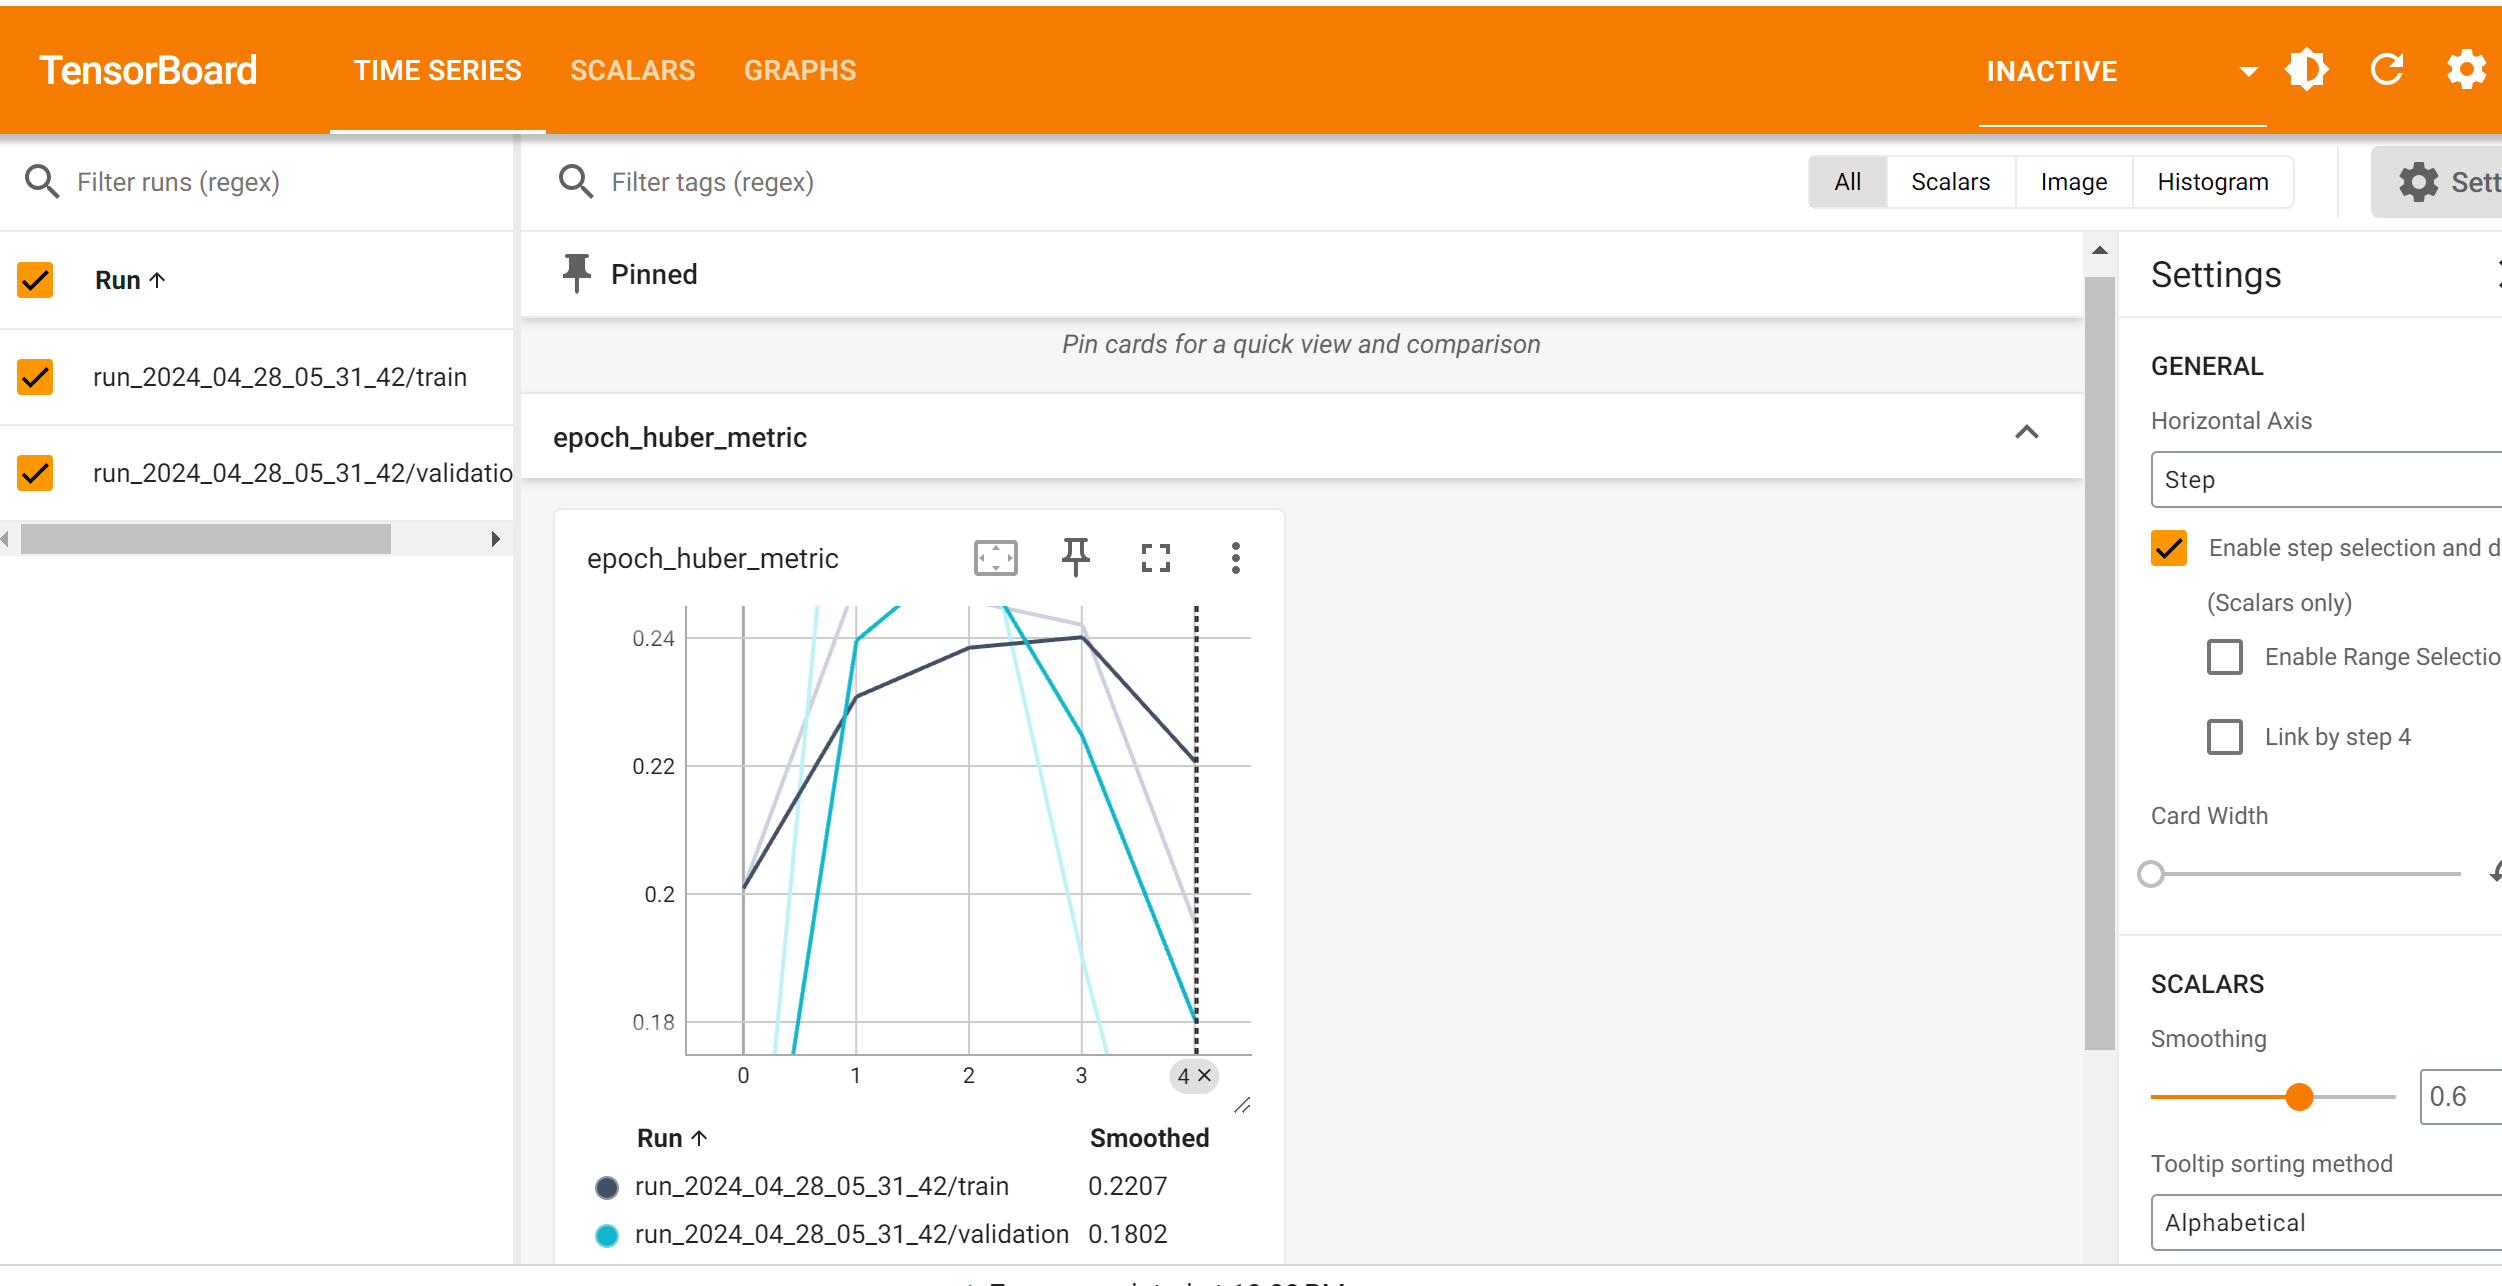

#Custom Models

In [129]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z


In [130]:
class ResidualRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [131]:
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train, y_train, epochs=5)
score = model.evaluate(X_test, y_test)

Epoch 1/5
25/25 [==============================] - 3s 3ms/step - loss: 0.6896
Epoch 2/5
25/25 [==============================] - 0s 3ms/step - loss: 0.5281
Epoch 3/5
25/25 [==============================] - 0s 3ms/step - loss: 0.4809
Epoch 4/5
25/25 [==============================] - 0s 2ms/step - loss: 0.5438
Epoch 5/5
7/7 [==============================] - 0s 4ms/step - loss: 0.3570


#Custom training loop

In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="selu", kernel_initializer=my_glorot_initializer,
                       kernel_regularizer = MyRegularizer(0.01),kernel_constraint = my_positive_weights ),
    MCAlphaDropout(rate=0.05),
    tf.keras.layers.Dense(10, activation=custom_activation, kernel_initializer=my_glorot_initializer,
                       input_shape=(3,),kernel_regularizer = MyRegularizer(0.01)),
    MaxNormDense(5),
    MyDense(1),
    tf.keras.layers.Dense(1),
])

model.compile(loss=HuberLoss(), optimizer='adam', metrics=[HuberMetric()])


In [49]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.MeanAbsoluteError()]

In [54]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [55]:
for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
800/800 [==============================] - mean: 9.8440 - mean_absolute_error: 2.2456
Epoch 2/5
800/800 [==============================] - mean: 2.5873 - mean_absolute_error: 1.0397
Epoch 3/5
800/800 [==============================] - mean: 2.1628 - mean_absolute_error: 0.8923
Epoch 4/5
800/800 [==============================] - mean: 1.7976 - mean_absolute_error: 0.7735
Epoch 5/5
800/800 [==============================] - mean: 1.7109 - mean_absolute_error: 0.7411
